# plotting functions of figure 2 in the manuscript
Overview plot of the first section. In the plot we show the result of reconstructing synthetic data simulated with Roodmus into a consensus (homogeneous) density map. 


In [18]:
# imports
import os
import re
import mrcfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# added following for 1to1 match prototyping
from tqdm import tqdm
from typing import Any
from collections.abc import KeysView as dict_keys

from gemmi import cif

# roodmus
from roodmus.analysis.utils import load_data
from roodmus.analysis.plot_picking import (
    plot_precision, plot_recall, 
)


In [2]:
# functions
def get_resolution_from_logs(project_dir, data, verbose=False):
    results ={
        "Nparticles": [],
        "res_unmasked": [],
        "res": [],
    }
    
    # load the logfiles and retrieve the resolutions
    for _, item in data.items():
        if verbose:
            print(f"Processing {item['PostProcess']}")
        Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
        pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+(\.\d+)?)"
        with open(Refine3D_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res_unmasked = float(re.search(pattern, line).group(1))
                    break

        PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
        pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
        with open(PostProcess_log, "r") as f:
            for line in f.readlines():
                if re.search(pattern, line):
                    res = float(re.search(pattern, line).group(1))
                    break
        
        if verbose:
            print(f"Nparticles: {item['Nparticles']}")
            print(f"res_unmasked: {res_unmasked}")
            print(f"res: {res}")
        results["Nparticles"].append(item["Nparticles"])
        results["res_unmasked"].append(res_unmasked)
        results["res"].append(res)

    return results


## panel A
plot of the 2D classes generated during processing of the homogeneous (single-conformation) data. The 2D classification used here was done after the final reconstruction, for visualisation only and on the full-sized images (320x320).
plot of the FSC curve from RELION.

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/figures/class_averages.pdf


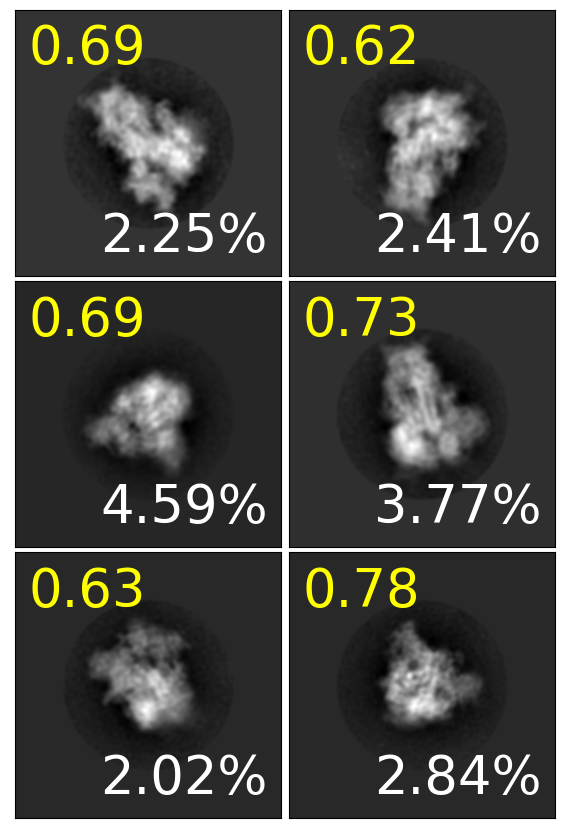

In [4]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job042", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job043", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'class_averages.pdf')}")

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/figures/job040_FSC.pdf


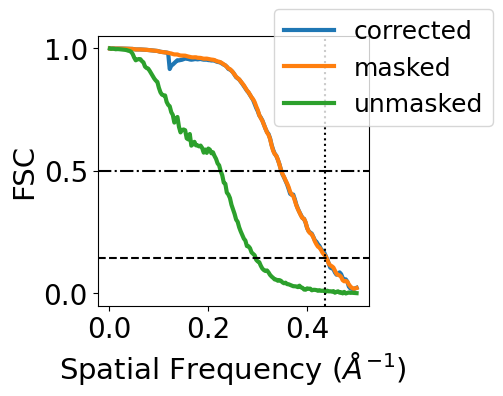

In [5]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
figures_dir = os.path.join(project_dir, "figures")
job = "job040"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
resolution = 2.29


fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected", linewidth=3)
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18, bbox_to_anchor=(0.65, 1.1), loc=2, borderaxespad=0.)

# fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'{job}_FSC.pdf')}")


## panel B
ResLog plot for single-conformation data set


B-factor masked: 17.77854567793456
saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/figures/ResLog.pdf


/tmp/ipykernel_27174/1947829536.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


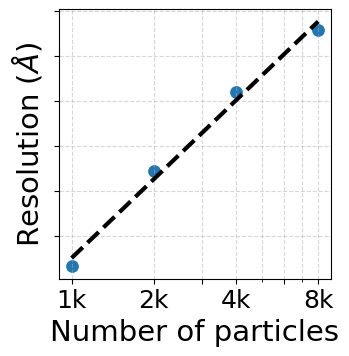

In [7]:
# data for single conformation set
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation"
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job037",
        "Refine3D": "job038",
        "MaskCreate": "job039",
        "PostProcess": "job040",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 3000, 4000, 6000, 8000])
ax.set_xticklabels(["1k", "2k", "", "4k", "", "8k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# fig.savefig(os.path.join(project_dir, "figures", "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(project_dir, 'figures', 'ResLog.pdf')}")


## panel C
2D classes for the heterogeneous data set
FSC curve for the heterogeneous data set

saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/class_averages.pdf


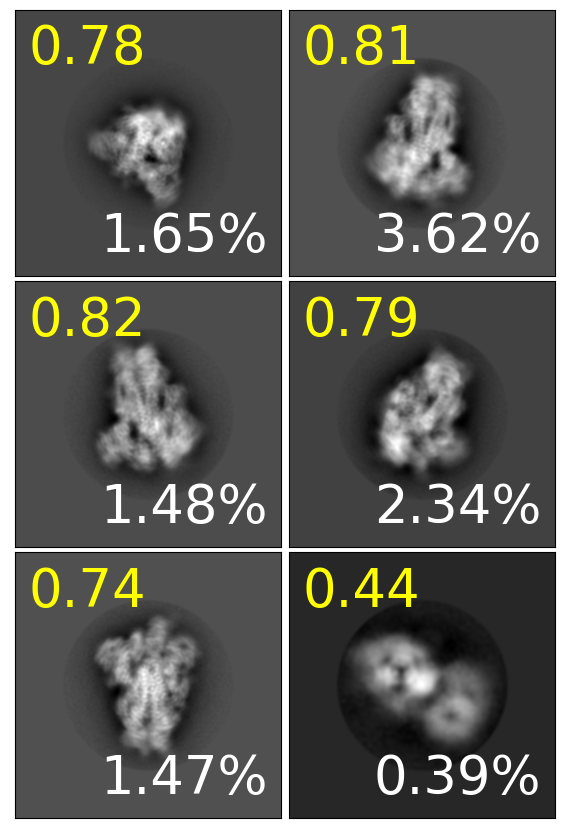

In [8]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
class_averages = os.path.join(project_dir, "Class2D", "job058", "run_it025_classes.mrcs")
ranker_output_file = os.path.join(project_dir, "Select", "job060", "class_averages.star")

num_rows = 3
num_columns = 2


class_averages_mrc = mrcfile.open(class_averages, mode='r')
class_ranker_cif = cif.read_file(ranker_output_file)
class_ranker_results = class_ranker_cif.sole_block()
rlnReferenceImage = class_ranker_results.find_loop('_rlnReferenceImage')
rlnPredictedClassScore = class_ranker_results.find_loop('_rlnPredictedClassScore')
rlnClassDistribution = class_ranker_results.find_loop('_rlnClassDistribution')
df = pd.DataFrame(data=[rlnReferenceImage, rlnPredictedClassScore, rlnClassDistribution], index=['rlnReferenceImage', 'rlnPredictedClassScore', 'rlnClassDistribution']).T
df["rlnPredictedClassScore"] = pd.to_numeric(df["rlnPredictedClassScore"])
df["rlnClassDistribution"] = pd.to_numeric(df["rlnClassDistribution"])
df["class_nr"] = df["rlnReferenceImage"].apply(lambda x: int(x.split('@')[0]))

fig, ax = plt.subplots(num_rows, num_columns, figsize=(3.5*num_columns, 3.5*num_rows))
for i, row in df.iterrows():
    if i >= num_rows * num_columns:
        break
    i_row = i // num_columns
    i_col = i % num_columns

    class_nr = row['class_nr']
    ax[i_row, i_col].imshow(class_averages_mrc.data[class_nr-1], cmap='gray', origin='upper')
    ax[i_row, i_col].set_xticks([])
    ax[i_row, i_col].set_yticks([])
    # ax[i_row, i_col].set_title('Class {}'.format(class_nr))
    # plot the predicted score as yellow text in the top left corner of the image
    ax[i_row, i_col].text(0.05, 0.95, '{:.2f}'.format(df['rlnPredictedClassScore'][i]), color='yellow', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='top')
    # plot the fraction of particles in the class as white text in the bottom right corner of the image
    ax[i_row, i_col].text(0.95, 0.05, '{:.2f}%'.format(df['rlnClassDistribution'][i]*100), color='white', transform=ax[i_row, i_col].transAxes, fontsize=38, verticalalignment='bottom', horizontalalignment='right')
# remove spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig.savefig(os.path.join(figures_dir, "class_averages.pdf"), bbox_inches='tight')
print(f"saved figure to: {os.path.join(figures_dir, 'class_averages.pdf')}")


saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/job016_FSC.pdf


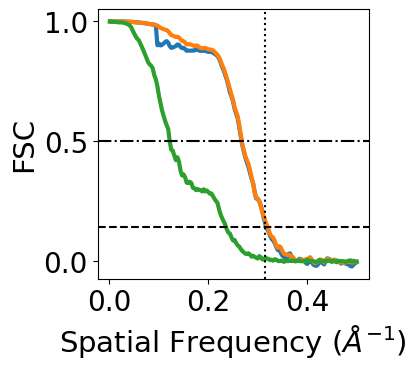

In [9]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
job = "job016"
fsc_postprocess_filename = os.path.join(project_dir, "PostProcess", job, "postprocess.star")
figures_dir = os.path.join(project_dir, "figures")
resolution = 3.17

fsc_cif = cif.read(fsc_postprocess_filename).find_block("fsc")
rlnResolution = fsc_cif.find_loop("_rlnResolution")
rlnFourierShellCorrelationCorrected = fsc_cif.find_loop("_rlnFourierShellCorrelationCorrected")
rlnFourierShellCorrelationParticleMaskFraction = fsc_cif.find_loop("_rlnFourierShellCorrelationParticleMaskFraction")
rlnFourierShellCorrelationUnmaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationUnmaskedMaps")
rlnFourierShellCorrelationMaskedMaps = fsc_cif.find_loop("_rlnFourierShellCorrelationMaskedMaps")
rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps = fsc_cif.find_loop("_rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps")

df = pd.DataFrame({
    "resolution": rlnResolution,
    "fsc": rlnFourierShellCorrelationCorrected,
    "fsc_masked": rlnFourierShellCorrelationMaskedMaps,
    "fsc_unmasked": rlnFourierShellCorrelationUnmaskedMaps,
    "fsc_masked_random": rlnCorrectedFourierShellCorrelationPhaseRandomizedMaskedMaps,
    "fsc_masked_fraction": rlnFourierShellCorrelationParticleMaskFraction,
})

# convert all columns to float
for column in df.columns:
    df[column] = df[column].astype(float)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.lineplot(x="resolution", y="fsc", data=df, ax=ax, legend=True, label="corrected", linewidth=3)
sns.lineplot(x="resolution", y="fsc_masked", data=df, ax=ax, legend=True, label="masked", linewidth=3)
sns.lineplot(x="resolution", y="fsc_unmasked", data=df, ax=ax, legend=True, label="unmasked", linewidth=3)
ax.axhline(0.143, color="black", linestyle="--")
ax.axhline(0.5, color="black", linestyle="-.")
ax.axvline(1/resolution, color="black", linestyle="dotted")
ax.set_xlabel("Spatial Frequency ($\AA^{-1}$)", fontsize=21)
ax.set_ylabel("FSC", fontsize=21)
# ax.set_ylim((-0.1, 1.25))
# change the fontsize of the ticks and the legend
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend().remove()

# fig.savefig(os.path.join(figures_dir, f"{job}_FSC.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, f'{job}_FSC.pdf')}")

## panel D
ResLog plot for the heterogeneous data set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B-factor masked: 41.09042363473794
saved figure to: /home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/ResLog.pdf


/tmp/ipykernel_27174/704394723.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


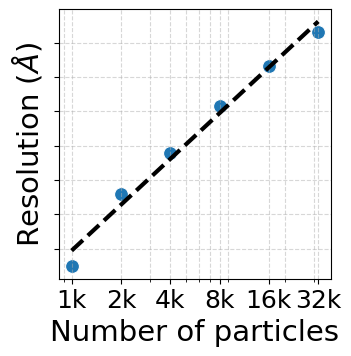

In [10]:
# data for full MD trajectory
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
figures_dir = os.path.join(project_dir, "figures")
data = {
    # 0: {
    #     "Nparticles": 250,
    #     "Select": "job033",
    #     "Refine3D": "job034",
    #     "MaskCreate": "job035",
    #     "PostProcess": "job036",
    # },
    # 1: {
    #     "Nparticles": 500,
    #     "Select": "job029",
    #     "Refine3D": "job030",
    #     "MaskCreate": "job031",
    #     "PostProcess": "job032",
    # },
    2: {
        "Nparticles": 1000,
        "Select": "job025",
        "Refine3D": "job026",
        "MaskCreate": "job027",
        "PostProcess": "job028",
    },
    3: {
        "Nparticles": 2000,
        "Select": "job021",
        "Refine3D": "job022",
        "MaskCreate": "job023",
        "PostProcess": "job024",
    },
    4: {
        "Nparticles": 4000,
        "Select": "job017",
        "Refine3D": "job018",
        "MaskCreate": "job019",
        "PostProcess": "job020",
    },
    5: {
        "Nparticles": 8000,
        "Select": "job006",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    6: {
        "Nparticles": 16000,
        "Select": "job050",
        "Refine3D": "job051",
        "MaskCreate": "job054",
        "PostProcess": "job055",
    },
    7: {
        "Nparticles": 32000,
        "Select": "job052",
        "Refine3D": "job053",
        "MaskCreate": "job056",
        "PostProcess": "job057",
    },
}
# load the logfiles and retrieve the resolutions
results = get_resolution_from_logs(project_dir, data, False)
results_df = pd.DataFrame(results)
# add column for 1/res^2
results_df["1/res2"] = 1/results_df["res"]**2
results_df["1/res_unmasked2"] = 1/results_df["res_unmasked"]**2
    
# plot the results
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.scatterplot(
    data=results_df, x="Nparticles", y="res", ax=ax, s=100,
)
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["res"], 1)
y = np.polyval(p, np.log10(results_df["Nparticles"]))
ax.plot(results_df["Nparticles"], y, color="black", linestyle="--", linewidth=3)
# compute B-factor as 2X slope
p = np.polyfit(np.log10(results_df["Nparticles"]), results_df["1/res2"], 1)
B_factor = 2/p[0]
print(f"B-factor masked: {B_factor}")

ax.set_xlabel("Number of particles", fontsize=21)
ax.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# invert x-axis
ax.invert_yaxis()
ax.legend().remove()

ax.set_xscale("log")
ax.set_xticks([1000, 2000, 4000, 8000, 16000, 32000])
ax.set_xticklabels(["1k", "2k", "4k", "8k", "16k", "32k"], fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# fig.savefig(os.path.join(figures_dir, "ResLog.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'ResLog.pdf')}")


## panel E
plot of the resolution dependence on the number of frames of the MD trajectory that are included in the particles. The total number of particles remains constant at 4000

saved figure to: /home/mjoosten1/projects/roodmus/data/20240102_limited_K_dataset/figures/resolution_Bfactor_vs_K.pdf


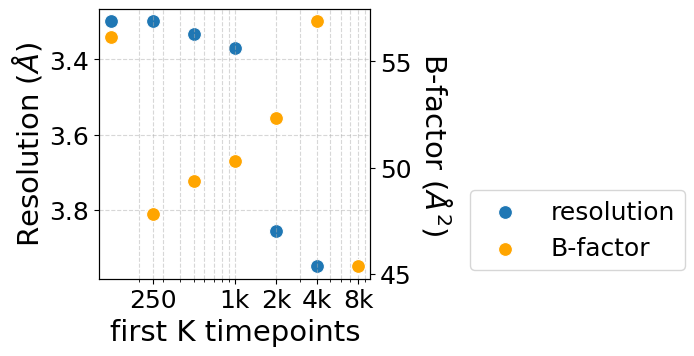

In [11]:
# define jobs to use
project_dir = "/home/mjoosten1/projects/roodmus/data/20240102_limited_K_dataset"
figures_dir = os.path.join(project_dir, "figures")

data = {
    0: {
        "K": 125,
        "Nparticles": 4000,
        "Import": "job007",
        "Refine3D": "job009",
        "MaskCreate": "job010",
        "PostProcess": "job011",
    },
    1: {
        "K": 8000,
        "Nparticles": 4000,
        "Import": "job012",
        "Refine3D": "job014",
        "MaskCreate": "job015",
        "PostProcess": "job016",
    },
    2: {
        "K": 250,
        "Nparticles": 4000,
        "Import": "job017",
        "Refine3D": "job019",
        "MaskCreate": "job020",
        "PostProcess": "job021",
    },
    3: {
        "K": 500,
        "Nparticles": 4000,
        "Import": "job022",
        "Refine3D": "job024",
        "MaskCreate": "job025",
        "PostProcess": "job026",
    },
    4: {
        "K": 1000,
        "Nparticles": 4000,
        "Import": "job027",
        "Refine3D": "job029",
        "MaskCreate": "job030",
        "PostProcess": "job031",
    },
    5: {
        "K": 2000,
        "Nparticles": 4000,
        "Import": "job032",
        "Refine3D": "job034",
        "MaskCreate": "job035",
        "PostProcess": "job036",
    },
    6: {
        "K": 4000,
        "Nparticles": 4000,
        "Import": "job037",
        "Refine3D": "job039",
        "MaskCreate": "job040",
        "PostProcess": "job041",
    },
}

results = {
    "K": [],
    "Nparticles": [],
    "res_unmasked": [],
    "res": [],
    "B_fac": [],
}

# loop over the jobs and get the resolution and B-factor from the log files
for _, item in data.items():
    Refine3D_log = os.path.join(project_dir, "Refine3D", item["Refine3D"], "run.out")
    pattern = r"Auto-refine: \+ Final resolution \(without masking\) is: (\d+\.\d+)"
    with open(Refine3D_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res_unmasked = float(re.search(pattern, line).group(1))
                break

    PostProcess_log = os.path.join(project_dir, "PostProcess", item["PostProcess"], "run.out")
    pattern = r"\+\s*FINAL\s+RESOLUTION:\s+(\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                res = float(re.search(pattern, line).group(1))
                break
    
    pattern = r"\+\s*apply\s+b-factor\s+of:\s+(-?\d+(\.\d+)?)"
    with open(PostProcess_log, "r") as f:
        for line in f.readlines():
            if re.search(pattern, line):
                B_fac = float(re.search(pattern, line).group(1))
                break

    results["K"].append(item["K"])
    results["Nparticles"].append(item["Nparticles"])
    results["res_unmasked"].append(res_unmasked)
    results["res"].append(res)
    results["B_fac"].append(-B_fac)
    # results["localres_std"].append(localres_std)

results_df = pd.DataFrame(results)
    
# plot the results
fig, ax_res = plt.subplots(figsize=(3.5, 3.5))
ax_Bfac = ax_res.twinx()
sns.scatterplot(
    data=results_df, x="K", y="res", ax=ax_res, label="resolution", s=100,
)
sns.scatterplot(
    data=results_df, x="K", y="B_fac", ax=ax_Bfac, label="B-factor", color="orange", s=100,
)
ax_res.set_xlabel("first K timepoints", fontsize=21)
ax_res.set_ylabel("Resolution ($\AA$)", fontsize=21)
ax_res.set_xscale("log")
ax_res.grid(axis="both", which="both", alpha=0.5, linestyle="--")
# ax_res.set_ylim((3.0, 4.1))
ax_res.invert_yaxis()
ax_Bfac.set_ylabel("B-factor ($\AA^2$)", fontsize=21, rotation=270, labelpad=30)
# ax_Bfac.set_ylim((40, 65))
# remove legends from the axis and add a single legend
ax_res.get_legend().remove()
ax_Bfac.get_legend().remove()
fig.legend(loc="upper left", bbox_to_anchor=(1.15, 0.40), ncol=1, fontsize=18)

# ax_Bfac.set_yticklabels(ax_Bfac.get_yticklabels(), fontsize=18)
# ax_res.set_yticklabels(ax_res.get_yticklabels(), fontsize=18)
ax_Bfac.tick_params(axis='y', labelsize=18)
ax_res.tick_params(axis='y', labelsize=18)
ax_res.set_xticks([250, 1000, 2000, 4000, 8000])
ax_res.set_xticklabels(["250", "1k", "2k", "4k", "8k"], fontsize=18)

# fig.savefig(os.path.join(figures_dir, "resolution_Bfactor_vs_K.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'resolution_Bfactor_vs_K.pdf')}")


## panel F
plot of the particle picking precision and recall throughout the processing of the heterogeneous data set

In [2]:
# project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
project_dir = "/mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA"
# project_dir = "/home/dvi41342/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA_subset"
config_dir = os.path.join(project_dir, "Micrographs")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "Extract", "job007", "particles.star"),
    #os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"),
    #os.path.join(project_dir, "Select", "job009", "particles.star"),
    # os.path.join(project_dir, "Select", "job036", "particles.star"),
    # os.path.join(project_dir, "Select", "job037", "particles.star"),
    # os.path.join(project_dir, "Select", "job038", "particles.star"),
    # os.path.join(project_dir, "Select", "job039", "particles.star"),
    ## os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"),
    ## os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"),
    ## os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Extract", "job007", "particles.star"): "topaz picker",
    #os.path.join(project_dir, "Class2D", "job008", "run_it200_data.star"): "2D classification",
    #os.path.join(project_dir, "Select", "job009", "particles.star"): "2D class selection",
    # os.path.join(project_dir, "Select", "job036", "particles.star"): "3D class 0",
    # os.path.join(project_dir, "Select", "job037", "particles.star"): "3D class 1",
    # os.path.join(project_dir, "Select", "job038", "particles.star"): "3D class 2",
    # os.path.join(project_dir, "Select", "job039", "particles.star"): "3D class 3",
    # os.path.join(project_dir, "Refine3D", "job014", "run_it015_data.star"): "Homogeneous refinement 1",
    # os.path.join(project_dir, "Refine3D", "job020", "run_it017_data.star"): "Homogeneous refinement 2",
    # os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"): "Homogeneous refinement 3",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
    
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
# df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
# print(f"mean precision: {df_precision['precision'].mean()}")
# print(f"mean recall: {df_precision['recall'].mean()}")

p_match, t_match, p_unmatched, t_unmatched = analysis._match_particles(
    meta_files[0], # need to loop over to repeat for each metadata file?
    df_picked,
    df_truth,
    verbose=True,
)
"""
results_picking = df_picked
results_truth = df_truth
metadata_filename = meta_files[0]
metafile_picked = results_picking.loc[
    results_picking["metadata_filename"] == metadata_filename
]
print("metafile_picked: {}".format(metafile_picked))
print("metafile_picked[ugraph_filename]: {}".format(metafile_picked["ugraph_filename"]))
metafile_truth = results_truth
print("metafile_picked.keys(): {}".format(metafile_picked.keys()))
print("ugraph_ids: {}".format(metafile_picked["ugraph_filename"].unique()))
"""


loading metadata from /mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star...
loaded metadata from /mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star. determined file type: star


Dictionaries now contain 240974 reconstructed particles
added 240974 particles from /mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Extract/job007/particles.star


loading truth data: 100%|██████████| 900/900 [07:12<00:00,  2.08it/s, micrograph=000899.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 240974 particles and 270000 true particles
Added 270000 particles from /mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs


computing closest matches:   0%|          | 4/900 [00:00<00:45, 19.61it/s]

Shape of 000000.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000000.mrc!
Shape of 000001.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000001.mrc!
Shape of 000002.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000002.mrc!
Shape of 000003.mrc
	sdm: (268, 300)
all nan slice in ugraph 000003.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:   1%|          | 8/900 [00:00<00:52, 16.92it/s]

There are 0 non-unique picked particles in ugraph 000004.mrc!
Shape of 000005.mrc
	sdm: (274, 300)
all nan slice in ugraph 000005.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   1%|▏         | 12/900 [00:00<00:48, 18.15it/s]

Shape of 000008.mrc
	sdm: (279, 300)
There are 0 non-unique picked particles in ugraph 000008.mrc!
Shape of 000009.mrc
	sdm: (274, 300)
all nan slice in ugraph 000009.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:   2%|▏         | 17/900 [00:00<00:47, 18.40it/s]

There are 0 non-unique picked particles in ugraph 000012.mrc!
Shape of 000013.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000013.mrc!
Shape of 000014.mrc
	sdm: (274, 300)
all nan slice in ugraph 000014.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:   2%|▏         | 21/900 [00:01<00:48, 18.13it/s]

Shape of 000017.mrc
	sdm: (267, 300)
all nan slice in ugraph 000017.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   3%|▎         | 25/900 [00:01<00:47, 18.43it/s]

Shape of 000021.mrc
	sdm: (261, 300)
all nan slice in ugraph 000021.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   3%|▎         | 29/900 [00:01<00:46, 18.55it/s]

There are 0 non-unique picked particles in ugraph 000025.mrc!
Shape of 000026.mrc
	sdm: (252, 300)
all nan slice in ugraph 000026.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   4%|▎         | 33/900 [00:01<00:45, 18.95it/s]

Shape of 000029.mrc
	sdm: (262, 300)
all nan slice in ugraph 000029.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   4%|▍         | 37/900 [00:02<00:44, 19.18it/s]

Shape of 000034.mrc
	sdm: (267, 300)
all nan slice in ugraph 000034.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   5%|▍         | 41/900 [00:02<00:45, 18.94it/s]

There are 0 non-unique picked particles in ugraph 000038.mrc!
Shape of 000039.mrc
	sdm: (265, 300)
all nan slice in ugraph 000039.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   5%|▌         | 45/900 [00:02<00:45, 18.77it/s]

all nan slice in ugraph 000042.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:   6%|▌         | 50/900 [00:02<00:43, 19.41it/s]

Shape of 000047.mrc
	sdm: (267, 300)
all nan slice in ugraph 000047.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   6%|▌         | 54/900 [00:02<00:43, 19.34it/s]

all nan slice in ugraph 000051.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:   7%|▋         | 59/900 [00:03<00:44, 19.09it/s]

Shape of 000056.mrc
	sdm: (273, 300)
all nan slice in ugraph 000056.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   7%|▋         | 63/900 [00:03<00:43, 19.19it/s]

Shape of 000060.mrc
	sdm: (277, 300)
all nan slice in ugraph 000060.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   7%|▋         | 67/900 [00:03<00:44, 18.56it/s]

There are 0 non-unique picked particles in ugraph 000064.mrc!
Shape of 000065.mrc
	sdm: (261, 300)
all nan slice in ugraph 000065.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   8%|▊         | 71/900 [00:03<00:44, 18.45it/s]

Shape of 000068.mrc
	sdm: (280, 300)
all nan slice in ugraph 000068.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:   8%|▊         | 75/900 [00:04<00:44, 18.66it/s]

all nan slice in ugraph 000072.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:   9%|▉         | 80/900 [00:04<00:44, 18.27it/s]

There are 0 non-unique picked particles in ugraph 000076.mrc!
Shape of 000077.mrc
	sdm: (273, 300)
all nan slice in ugraph 000077.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:   9%|▉         | 84/900 [00:04<00:45, 18.06it/s]

Shape of 000080.mrc
	sdm: (275, 300)
all nan slice in ugraph 000080.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  10%|▉         | 88/900 [00:04<00:44, 18.25it/s]

Shape of 000084.mrc
	sdm: (272, 300)
all nan slice in ugraph 000084.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  10%|█         | 92/900 [00:04<00:43, 18.58it/s]

Shape of 000088.mrc
	sdm: (271, 300)
all nan slice in ugraph 000088.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  11%|█         | 96/900 [00:05<00:42, 18.86it/s]

Shape of 000092.mrc
	sdm: (270, 300)
all nan slice in ugraph 000092.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  11%|█         | 100/900 [00:05<00:42, 19.01it/s]

Shape of 000096.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000096.mrc!
Shape of 000097.mrc
	sdm: (270, 300)
all nan slice in ugraph 000097.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  12%|█▏        | 104/900 [00:05<00:43, 18.36it/s]

There are 0 non-unique picked particles in ugraph 000100.mrc!
Shape of 000101.mrc
	sdm: (268, 300)
all nan slice in ugraph 000101.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  12%|█▏        | 108/900 [00:05<00:41, 19.05it/s]

Shape of 000105.mrc
	sdm: (272, 300)
all nan slice in ugraph 000105.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  13%|█▎        | 113/900 [00:06<00:41, 19.17it/s]

There are 0 non-unique picked particles in ugraph 000109.mrc!
Shape of 000110.mrc
	sdm: (262, 300)
all nan slice in ugraph 000110.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  13%|█▎        | 117/900 [00:06<00:41, 18.89it/s]

Shape of 000114.mrc
	sdm: (268, 300)
all nan slice in ugraph 000114.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  13%|█▎        | 121/900 [00:06<00:41, 18.83it/s]

Shape of 000118.mrc
	sdm: (270, 300)
all nan slice in ugraph 000118.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▍        | 125/900 [00:06<00:41, 18.79it/s]

Shape of 000122.mrc
	sdm: (257, 300)
all nan slice in ugraph 000122.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  14%|█▍        | 129/900 [00:06<00:41, 18.68it/s]

Shape of 000126.mrc
	sdm: (272, 300)
all nan slice in ugraph 000126.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  15%|█▍        | 133/900 [00:07<00:41, 18.32it/s]

Shape of 000130.mrc
	sdm: (262, 300)
all nan slice in ugraph 000130.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  15%|█▌        | 137/900 [00:07<00:40, 18.91it/s]

There are 0 non-unique picked particles in ugraph 000134.mrc!
Shape of 000135.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000135.mrc!
Shape of 000136.mrc
	sdm: (259, 300)
all nan slice in ugraph 000136.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  16%|█▌        | 141/900 [00:07<00:40, 18.88it/s]

There are 0 non-unique picked particles in ugraph 000138.mrc!
Shape of 000139.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000139.mrc!
Shape of 000140.mrc
	sdm: (275, 300)
all nan slice in ugraph 000140.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  16%|█▌        | 145/900 [00:07<00:41, 18.02it/s]

There are 0 non-unique picked particles in ugraph 000142.mrc!
Shape of 000143.mrc
	sdm: (273, 300)
all nan slice in ugraph 000143.mrc with picked particle index 234 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  17%|█▋        | 149/900 [00:07<00:40, 18.62it/s]

Shape of 000146.mrc
	sdm: (267, 300)
all nan slice in ugraph 000146.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  17%|█▋        | 153/900 [00:08<00:39, 18.79it/s]

There are 0 non-unique picked particles in ugraph 000150.mrc!
Shape of 000151.mrc
	sdm: (265, 300)
all nan slice in ugraph 000151.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  17%|█▋        | 157/900 [00:08<00:38, 19.11it/s]

all nan slice in ugraph 000154.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  18%|█▊        | 161/900 [00:08<00:39, 18.63it/s]

all nan slice in ugraph 000158.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  18%|█▊        | 165/900 [00:08<00:39, 18.40it/s]

There are 0 non-unique picked particles in ugraph 000162.mrc!
Shape of 000163.mrc
	sdm: (277, 300)
all nan slice in ugraph 000163.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  19%|█▉        | 169/900 [00:09<00:40, 18.18it/s]

Shape of 000166.mrc
	sdm: (268, 300)
all nan slice in ugraph 000166.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  19%|█▉        | 174/900 [00:09<00:37, 19.14it/s]

Shape of 000170.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000170.mrc!
Shape of 000171.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000171.mrc!
Shape of 000172.mrc
	sdm: (261, 300)
all nan slice in ugraph 000172.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  20%|█▉        | 178/900 [00:09<00:38, 18.62it/s]

There are 0 non-unique picked particles in ugraph 000174.mrc!
Shape of 000175.mrc
	sdm: (262, 300)
all nan slice in ugraph 000175.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  20%|██        | 182/900 [00:09<00:38, 18.57it/s]

There are 0 non-unique picked particles in ugraph 000178.mrc!
Shape of 000179.mrc
	sdm: (268, 300)
all nan slice in ugraph 000179.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  21%|██        | 186/900 [00:09<00:38, 18.59it/s]

Shape of 000182.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000182.mrc!
Shape of 000183.mrc
	sdm: (268, 300)
all nan slice in ugraph 000183.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  21%|██        | 190/900 [00:10<00:38, 18.53it/s]

Shape of 000186.mrc
	sdm: (270, 300)
all nan slice in ugraph 000186.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  22%|██▏       | 194/900 [00:10<00:37, 18.88it/s]

There are 0 non-unique picked particles in ugraph 000190.mrc!
Shape of 000191.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000191.mrc!
Shape of 000192.mrc
	sdm: (269, 300)
all nan slice in ugraph 000192.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  22%|██▏       | 198/900 [00:10<00:37, 18.93it/s]

Shape of 000195.mrc
	sdm: (267, 300)
all nan slice in ugraph 000195.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  23%|██▎       | 203/900 [00:10<00:35, 19.42it/s]

There are 0 non-unique picked particles in ugraph 000199.mrc!
Shape of 000200.mrc
	sdm: (271, 300)
all nan slice in ugraph 000200.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  23%|██▎       | 207/900 [00:11<00:36, 19.14it/s]

Shape of 000204.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000204.mrc!
Shape of 000205.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000205.mrc!
Shape of 000206.mrc
	sdm: (270, 300)
all nan slice in ugraph 000206.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  24%|██▎       | 212/900 [00:11<00:35, 19.43it/s]

There are 0 non-unique picked particles in ugraph 000208.mrc!
Shape of 000209.mrc
	sdm: (272, 300)
all nan slice in ugraph 000209.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  24%|██▍       | 215/900 [00:11<00:35, 19.57it/s]

There are 0 non-unique picked particles in ugraph 000212.mrc!
Shape of 000213.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000213.mrc!
Shape of 000214.mrc
	sdm: (272, 300)
all nan slice in ugraph 000214.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  24%|██▍       | 219/900 [00:11<00:35, 19.20it/s]

There are 0 non-unique picked particles in ugraph 000216.mrc!
Shape of 000217.mrc
	sdm: (273, 300)
all nan slice in ugraph 000217.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  25%|██▍       | 224/900 [00:11<00:35, 19.28it/s]

There are 0 non-unique picked particles in ugraph 000220.mrc!
Shape of 000221.mrc
	sdm: (268, 300)
all nan slice in ugraph 000221.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  25%|██▌       | 228/900 [00:12<00:37, 17.80it/s]

Shape of 000225.mrc
	sdm: (260, 300)
all nan slice in ugraph 000225.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  26%|██▌       | 232/900 [00:12<00:37, 17.84it/s]

Shape of 000229.mrc
	sdm: (275, 300)
all nan slice in ugraph 000229.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  26%|██▌       | 236/900 [00:12<00:37, 17.88it/s]

Shape of 000233.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000233.mrc!
Shape of 000234.mrc
	sdm: (271, 300)
all nan slice in ugraph 000234.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  27%|██▋       | 240/900 [00:12<00:36, 18.18it/s]

Shape of 000237.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000237.mrc!
Shape of 000238.mrc
	sdm: (271, 300)
all nan slice in ugraph 000238.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  27%|██▋       | 244/900 [00:13<00:35, 18.34it/s]

Shape of 000241.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000241.mrc!
Shape of 000242.mrc
	sdm: (262, 300)
all nan slice in ugraph 000242.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  28%|██▊       | 248/900 [00:13<00:34, 18.95it/s]

There are 0 non-unique picked particles in ugraph 000245.mrc!
Shape of 000246.mrc
	sdm: (267, 300)
all nan slice in ugraph 000246.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  28%|██▊       | 252/900 [00:13<00:34, 18.94it/s]

There are 0 non-unique picked particles in ugraph 000249.mrc!
Shape of 000250.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000250.mrc!
Shape of 000251.mrc
	sdm: (273, 300)
all nan slice in ugraph 000251.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  28%|██▊       | 256/900 [00:13<00:34, 18.72it/s]

Shape of 000253.mrc
	sdm: (266, 300)
all nan slice in ugraph 000253.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  29%|██▉       | 260/900 [00:13<00:33, 19.14it/s]

all nan slice in ugraph 000257.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  29%|██▉       | 265/900 [00:14<00:33, 19.07it/s]

Shape of 000262.mrc
	sdm: (266, 300)
all nan slice in ugraph 000262.mrc with picked particle index 237 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  30%|██▉       | 269/900 [00:14<00:33, 19.12it/s]

Shape of 000266.mrc
	sdm: (266, 300)
all nan slice in ugraph 000266.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  30%|███       | 273/900 [00:14<00:32, 19.29it/s]

There are 0 non-unique picked particles in ugraph 000270.mrc!
Shape of 000271.mrc
	sdm: (265, 300)
all nan slice in ugraph 000271.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  31%|███       | 277/900 [00:14<00:33, 18.62it/s]

all nan slice in ugraph 000274.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  31%|███▏      | 282/900 [00:15<00:32, 18.90it/s]

There are 0 non-unique picked particles in ugraph 000278.mrc!
Shape of 000279.mrc
	sdm: (257, 300)
There are 0 non-unique picked particles in ugraph 000279.mrc!
Shape of 000280.mrc
	sdm: (267, 300)
all nan slice in ugraph 000280.mrc with picked particle index 246 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  32%|███▏      | 286/900 [00:15<00:32, 18.97it/s]

Shape of 000282.mrc
	sdm: (271, 300)
all nan slice in ugraph 000282.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  32%|███▏      | 290/900 [00:15<00:32, 18.72it/s]

There are 0 non-unique picked particles in ugraph 000286.mrc!
Shape of 000287.mrc
	sdm: (271, 300)
all nan slice in ugraph 000287.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  33%|███▎      | 294/900 [00:15<00:32, 18.60it/s]

There are 0 non-unique picked particles in ugraph 000290.mrc!
Shape of 000291.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000291.mrc!
Shape of 000292.mrc
	sdm: (270, 300)
all nan slice in ugraph 000292.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  33%|███▎      | 299/900 [00:15<00:31, 19.37it/s]

all nan slice in ugraph 000294.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  34%|███▎      | 303/900 [00:16<00:31, 19.20it/s]

Shape of 000299.mrc
	sdm: (268, 300)
all nan slice in ugraph 000299.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  34%|███▍      | 307/900 [00:16<00:32, 18.05it/s]

Shape of 000304.mrc
	sdm: (274, 300)
all nan slice in ugraph 000304.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  35%|███▍      | 312/900 [00:16<00:31, 18.90it/s]

Shape of 000308.mrc
	sdm: (270, 300)
all nan slice in ugraph 000308.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  35%|███▌      | 316/900 [00:16<00:31, 18.55it/s]

There are 0 non-unique picked particles in ugraph 000312.mrc!
Shape of 000313.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000313.mrc!
Shape of 000314.mrc
	sdm: (264, 300)
all nan slice in ugraph 000314.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  36%|███▌      | 320/900 [00:17<00:31, 18.16it/s]

Shape of 000316.mrc
	sdm: (271, 300)
all nan slice in ugraph 000316.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  36%|███▌      | 323/900 [00:17<00:30, 18.97it/s]

Shape of 000320.mrc
	sdm: (267, 300)
all nan slice in ugraph 000320.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  36%|███▋      | 327/900 [00:17<00:31, 18.45it/s]

Shape of 000324.mrc
	sdm: (273, 300)
all nan slice in ugraph 000324.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  37%|███▋      | 331/900 [00:17<00:30, 18.66it/s]

Shape of 000328.mrc
	sdm: (277, 300)
all nan slice in ugraph 000328.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  37%|███▋      | 336/900 [00:17<00:29, 19.08it/s]

Shape of 000333.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000333.mrc!
Shape of 000334.mrc
	sdm: (269, 300)
all nan slice in ugraph 000334.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  38%|███▊      | 341/900 [00:18<00:28, 19.40it/s]

There are 0 non-unique picked particles in ugraph 000337.mrc!
Shape of 000338.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000338.mrc!
Shape of 000339.mrc
	sdm: (274, 300)
all nan slice in ugraph 000339.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  38%|███▊      | 345/900 [00:18<00:29, 18.74it/s]

There are 0 non-unique picked particles in ugraph 000341.mrc!
Shape of 000342.mrc
	sdm: (267, 300)
all nan slice in ugraph 000342.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  39%|███▉      | 349/900 [00:18<00:28, 19.03it/s]

There are 0 non-unique picked particles in ugraph 000345.mrc!
Shape of 000346.mrc
	sdm: (272, 300)
all nan slice in ugraph 000346.mrc with picked particle index 269 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  39%|███▉      | 352/900 [00:18<00:28, 19.53it/s]

There are 0 non-unique picked particles in ugraph 000349.mrc!
Shape of 000350.mrc
	sdm: (267, 300)
all nan slice in ugraph 000350.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  40%|███▉      | 357/900 [00:19<00:28, 18.97it/s]

all nan slice in ugraph 000353.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  40%|████      | 361/900 [00:19<00:29, 18.57it/s]

Shape of 000357.mrc
	sdm: (263, 300)
all nan slice in ugraph 000357.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  41%|████      | 365/900 [00:19<00:30, 17.74it/s]

Shape of 000361.mrc
	sdm: (267, 300)
all nan slice in ugraph 000361.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  41%|████      | 369/900 [00:19<00:29, 17.99it/s]

Shape of 000365.mrc
	sdm: (275, 300)
all nan slice in ugraph 000365.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  41%|████▏     | 373/900 [00:19<00:29, 17.93it/s]

all nan slice in ugraph 000369.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  42%|████▏     | 377/900 [00:20<00:28, 18.20it/s]

There are 0 non-unique picked particles in ugraph 000373.mrc!
Shape of 000374.mrc
	sdm: (275, 300)
all nan slice in ugraph 000374.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  42%|████▏     | 381/900 [00:20<00:28, 18.21it/s]

Shape of 000377.mrc
	sdm: (268, 300)
all nan slice in ugraph 000377.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 385/900 [00:20<00:27, 18.51it/s]

Shape of 000381.mrc
	sdm: (271, 300)
all nan slice in ugraph 000381.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  43%|████▎     | 389/900 [00:20<00:27, 18.41it/s]

There are 0 non-unique picked particles in ugraph 000385.mrc!
Shape of 000386.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000386.mrc!
Shape of 000387.mrc
	sdm: (275, 300)
all nan slice in ugraph 000387.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  44%|████▎     | 393/900 [00:21<00:27, 18.33it/s]

There are 0 non-unique picked particles in ugraph 000389.mrc!
Shape of 000390.mrc
	sdm: (272, 300)
There are 0 non-unique picked particles in ugraph 000390.mrc!
Shape of 000391.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000391.mrc!
Shape of 000392.mrc
	sdm: (273, 300)
all nan slice in ugraph 000392.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  44%|████▍     | 397/900 [00:21<00:26, 18.77it/s]

There are 0 non-unique picked particles in ugraph 000393.mrc!
Shape of 000394.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000394.mrc!
Shape of 000395.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000395.mrc!
Shape of 000396.mrc
	sdm: (267, 300)
all nan slice in ugraph 000396.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  45%|████▍     | 401/900 [00:21<00:26, 19.11it/s]

There are 0 non-unique picked particles in ugraph 000397.mrc!
Shape of 000398.mrc
	sdm: (283, 300)
all nan slice in ugraph 000398.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  45%|████▌     | 405/900 [00:21<00:26, 18.72it/s]

There are 0 non-unique picked particles in ugraph 000401.mrc!
Shape of 000402.mrc
	sdm: (269, 300)
all nan slice in ugraph 000402.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  45%|████▌     | 409/900 [00:21<00:26, 18.72it/s]

Shape of 000405.mrc
	sdm: (264, 300)
all nan slice in ugraph 000405.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  46%|████▌     | 413/900 [00:22<00:26, 18.37it/s]

There are 0 non-unique picked particles in ugraph 000409.mrc!
Shape of 000410.mrc
	sdm: (262, 300)
all nan slice in ugraph 000410.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  46%|████▋     | 417/900 [00:22<00:26, 18.38it/s]

There are 0 non-unique picked particles in ugraph 000413.mrc!
Shape of 000414.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000414.mrc!
Shape of 000415.mrc
	sdm: (276, 300)
all nan slice in ugraph 000415.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  47%|████▋     | 421/900 [00:22<00:26, 17.94it/s]

Shape of 000417.mrc
	sdm: (259, 300)
all nan slice in ugraph 000417.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  47%|████▋     | 423/900 [00:22<00:25, 18.42it/s]

Shape of 000421.mrc
	sdm: (263, 300)
all nan slice in ugraph 000421.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  48%|████▊     | 430/900 [00:23<00:26, 17.95it/s]

Shape of 000426.mrc
	sdm: (275, 300)
all nan slice in ugraph 000426.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  48%|████▊     | 434/900 [00:23<00:25, 18.03it/s]

Shape of 000430.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000430.mrc!
Shape of 000431.mrc
	sdm: (264, 300)
all nan slice in ugraph 000431.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  49%|████▊     | 438/900 [00:23<00:26, 17.67it/s]

Shape of 000434.mrc
	sdm: (276, 300)
all nan slice in ugraph 000434.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  49%|████▉     | 442/900 [00:23<00:25, 18.09it/s]

Shape of 000438.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000438.mrc!
Shape of 000439.mrc
	sdm: (269, 300)
all nan slice in ugraph 000439.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  50%|████▉     | 446/900 [00:23<00:24, 18.54it/s]

Shape of 000442.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000442.mrc!
Shape of 000443.mrc
	sdm: (268, 300)
all nan slice in ugraph 000443.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  50%|█████     | 450/900 [00:24<00:23, 18.76it/s]

There are 0 non-unique picked particles in ugraph 000446.mrc!
Shape of 000447.mrc
	sdm: (271, 300)
all nan slice in ugraph 000447.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  50%|█████     | 453/900 [00:24<00:23, 19.24it/s]

There are 0 non-unique picked particles in ugraph 000450.mrc!
Shape of 000451.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000451.mrc!
Shape of 000452.mrc
	sdm: (265, 300)
all nan slice in ugraph 000452.mrc with picked particle index 249 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  51%|█████     | 458/900 [00:24<00:22, 19.38it/s]

Shape of 000455.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000455.mrc!
Shape of 000456.mrc
	sdm: (261, 300)
all nan slice in ugraph 000456.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  51%|█████▏    | 463/900 [00:24<00:22, 19.12it/s]

Shape of 000459.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000459.mrc!
Shape of 000460.mrc
	sdm: (245, 300)
There are 0 non-unique picked particles in ugraph 000460.mrc!
Shape of 000461.mrc
	sdm: (265, 300)
all nan slice in ugraph 000461.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  52%|█████▏    | 467/900 [00:25<00:23, 18.79it/s]

Shape of 000463.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000463.mrc!
Shape of 000464.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000464.mrc!
Shape of 000465.mrc
	sdm: (257, 300)
all nan slice in ugraph 000465.mrc with picked particle index 243 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  52%|█████▏    | 471/900 [00:25<00:23, 18.49it/s]

Shape of 000467.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000467.mrc!
Shape of 000468.mrc
	sdm: (261, 300)
all nan slice in ugraph 000468.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  53%|█████▎    | 473/900 [00:25<00:23, 18.04it/s]

There are 0 non-unique picked particles in ugraph 000471.mrc!
Shape of 000472.mrc
	sdm: (269, 300)
all nan slice in ugraph 000472.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  53%|█████▎    | 478/900 [00:25<00:22, 18.68it/s]

There are 0 non-unique picked particles in ugraph 000475.mrc!
Shape of 000476.mrc
	sdm: (270, 300)
all nan slice in ugraph 000476.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  54%|█████▎    | 482/900 [00:25<00:22, 18.38it/s]

Shape of 000479.mrc
	sdm: (263, 300)
all nan slice in ugraph 000479.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  54%|█████▍    | 486/900 [00:26<00:22, 18.01it/s]

There are 0 non-unique picked particles in ugraph 000483.mrc!
Shape of 000484.mrc
	sdm: (270, 300)
all nan slice in ugraph 000484.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  54%|█████▍    | 490/900 [00:26<00:23, 17.45it/s]

Shape of 000487.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000487.mrc!
Shape of 000488.mrc
	sdm: (268, 300)
There are 0 non-unique picked particles in ugraph 000488.mrc!
Shape of 000489.mrc
	sdm: (278, 300)
all nan slice in ugraph 000489.mrc with picked particle index 240 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  55%|█████▍    | 494/900 [00:26<00:22, 18.00it/s]

Shape of 000491.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000491.mrc!
Shape of 000492.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000492.mrc!
Shape of 000493.mrc
	sdm: (262, 300)
all nan slice in ugraph 000493.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  55%|█████▌    | 499/900 [00:26<00:21, 18.34it/s]

Shape of 000496.mrc
	sdm: (255, 300)
There are 0 non-unique picked particles in ugraph 000496.mrc!
Shape of 000497.mrc
	sdm: (264, 300)
all nan slice in ugraph 000497.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  56%|█████▌    | 503/900 [00:27<00:21, 18.14it/s]

Shape of 000500.mrc
	sdm: (269, 300)
all nan slice in ugraph 000500.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  56%|█████▋    | 507/900 [00:27<00:23, 17.04it/s]

Shape of 000504.mrc
	sdm: (277, 300)
all nan slice in ugraph 000504.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  57%|█████▋    | 511/900 [00:27<00:22, 17.33it/s]

Shape of 000508.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000508.mrc!
Shape of 000509.mrc
	sdm: (264, 300)
all nan slice in ugraph 000509.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  57%|█████▋    | 515/900 [00:27<00:22, 17.27it/s]

Shape of 000512.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000512.mrc!
Shape of 000513.mrc
	sdm: (272, 300)
all nan slice in ugraph 000513.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  58%|█████▊    | 519/900 [00:27<00:21, 17.68it/s]

Shape of 000516.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000516.mrc!
Shape of 000517.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000517.mrc!
Shape of 000518.mrc
	sdm: (265, 300)
all nan slice in ugraph 000518.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  58%|█████▊    | 523/900 [00:28<00:20, 18.27it/s]

There are 0 non-unique picked particles in ugraph 000520.mrc!
Shape of 000521.mrc
	sdm: (260, 300)
all nan slice in ugraph 000521.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  59%|█████▊    | 528/900 [00:28<00:19, 18.76it/s]

Shape of 000524.mrc
	sdm: (268, 300)
all nan slice in ugraph 000524.mrc with picked particle index 248 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  59%|█████▉    | 532/900 [00:28<00:20, 17.70it/s]

Shape of 000529.mrc
	sdm: (263, 300)
all nan slice in ugraph 000529.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|█████▉    | 536/900 [00:28<00:21, 17.20it/s]

Shape of 000533.mrc
	sdm: (265, 300)
all nan slice in ugraph 000533.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|██████    | 540/900 [00:29<00:20, 17.54it/s]

Shape of 000537.mrc
	sdm: (267, 300)
all nan slice in ugraph 000537.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  60%|██████    | 544/900 [00:29<00:20, 17.23it/s]

Shape of 000541.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000541.mrc!
Shape of 000542.mrc
	sdm: (273, 300)
all nan slice in ugraph 000542.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  61%|██████    | 548/900 [00:29<00:20, 17.16it/s]

Shape of 000545.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000545.mrc!
Shape of 000546.mrc
	sdm: (269, 300)
all nan slice in ugraph 000546.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  61%|██████▏   | 552/900 [00:29<00:19, 17.55it/s]

Shape of 000549.mrc
	sdm: (266, 300)
all nan slice in ugraph 000549.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  62%|██████▏   | 556/900 [00:30<00:18, 18.19it/s]

Shape of 000553.mrc
	sdm: (260, 300)
all nan slice in ugraph 000553.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  62%|██████▏   | 560/900 [00:30<00:18, 18.55it/s]

There are 0 non-unique picked particles in ugraph 000557.mrc!
Shape of 000558.mrc
	sdm: (265, 300)
all nan slice in ugraph 000558.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  63%|██████▎   | 565/900 [00:30<00:17, 18.82it/s]

Shape of 000562.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000562.mrc!
Shape of 000563.mrc
	sdm: (268, 300)
all nan slice in ugraph 000563.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  63%|██████▎   | 570/900 [00:30<00:17, 18.77it/s]

Shape of 000566.mrc
	sdm: (273, 300)
all nan slice in ugraph 000566.mrc with picked particle index 231 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  64%|██████▍   | 574/900 [00:30<00:17, 18.47it/s]

There are 0 non-unique picked particles in ugraph 000570.mrc!
Shape of 000571.mrc
	sdm: (267, 300)
all nan slice in ugraph 000571.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  64%|██████▍   | 578/900 [00:31<00:17, 18.77it/s]

Shape of 000574.mrc
	sdm: (271, 300)
all nan slice in ugraph 000574.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  64%|██████▍   | 580/900 [00:31<00:17, 18.27it/s]

Shape of 000578.mrc
	sdm: (267, 300)
all nan slice in ugraph 000578.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  65%|██████▌   | 585/900 [00:31<00:16, 18.89it/s]

There are 0 non-unique picked particles in ugraph 000582.mrc!
Shape of 000583.mrc
	sdm: (261, 300)
all nan slice in ugraph 000583.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  65%|██████▌   | 589/900 [00:31<00:17, 18.01it/s]

Shape of 000586.mrc
	sdm: (274, 300)
all nan slice in ugraph 000586.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  66%|██████▌   | 593/900 [00:32<00:17, 17.59it/s]

Shape of 000590.mrc
	sdm: (268, 300)
all nan slice in ugraph 000590.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  66%|██████▋   | 597/900 [00:32<00:17, 17.75it/s]

Shape of 000594.mrc
	sdm: (272, 300)
all nan slice in ugraph 000594.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  67%|██████▋   | 601/900 [00:32<00:16, 18.52it/s]

Shape of 000598.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000598.mrc!
Shape of 000599.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000599.mrc!
Shape of 000600.mrc
	sdm: (272, 300)
all nan slice in ugraph 000600.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  67%|██████▋   | 605/900 [00:32<00:16, 18.11it/s]

Shape of 000602.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000602.mrc!
Shape of 000603.mrc
	sdm: (270, 300)
all nan slice in ugraph 000603.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  68%|██████▊   | 610/900 [00:32<00:15, 18.79it/s]

Shape of 000606.mrc
	sdm: (267, 300)
all nan slice in ugraph 000606.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  68%|██████▊   | 614/900 [00:33<00:15, 18.81it/s]

all nan slice in ugraph 000610.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  69%|██████▊   | 618/900 [00:33<00:15, 18.42it/s]

Shape of 000615.mrc
	sdm: (273, 300)
all nan slice in ugraph 000615.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  69%|██████▉   | 622/900 [00:33<00:14, 18.85it/s]

There are 0 non-unique picked particles in ugraph 000619.mrc!
Shape of 000620.mrc
	sdm: (276, 300)
all nan slice in ugraph 000620.mrc with picked particle index 273 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  70%|██████▉   | 626/900 [00:33<00:15, 18.20it/s]

Shape of 000623.mrc
	sdm: (268, 300)
all nan slice in ugraph 000623.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  70%|███████   | 630/900 [00:34<00:14, 18.13it/s]

Shape of 000627.mrc
	sdm: (270, 300)
all nan slice in ugraph 000627.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  70%|███████   | 634/900 [00:34<00:14, 18.50it/s]

Shape of 000631.mrc
	sdm: (270, 300)
all nan slice in ugraph 000631.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  71%|███████   | 638/900 [00:34<00:13, 19.00it/s]

Shape of 000635.mrc
	sdm: (271, 300)
all nan slice in ugraph 000635.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  71%|███████▏  | 642/900 [00:34<00:14, 17.55it/s]

Shape of 000639.mrc
	sdm: (274, 300)
all nan slice in ugraph 000639.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  72%|███████▏  | 647/900 [00:34<00:13, 18.51it/s]

Shape of 000643.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000643.mrc!
Shape of 000644.mrc
	sdm: (265, 300)
There are 0 non-unique picked particles in ugraph 000644.mrc!
Shape of 000645.mrc
	sdm: (266, 300)
all nan slice in ugraph 000645.mrc with picked particle index 242 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  72%|███████▏  | 651/900 [00:35<00:13, 18.15it/s]

all nan slice in ugraph 000647.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  73%|███████▎  | 653/900 [00:35<00:13, 17.99it/s]

Shape of 000651.mrc
	sdm: (276, 300)
all nan slice in ugraph 000651.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  73%|███████▎  | 657/900 [00:35<00:18, 12.84it/s]

Shape of 000653.mrc
	sdm: (265, 300)
all nan slice in ugraph 000653.mrc with picked particle index 243 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  73%|███████▎  | 661/900 [00:35<00:15, 15.07it/s]

Shape of 000657.mrc
	sdm: (271, 300)
all nan slice in ugraph 000657.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  74%|███████▍  | 665/900 [00:36<00:14, 16.45it/s]

Shape of 000661.mrc
	sdm: (275, 300)
all nan slice in ugraph 000661.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  74%|███████▍  | 668/900 [00:36<00:13, 17.68it/s]

Shape of 000665.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000665.mrc!
Shape of 000666.mrc
	sdm: (263, 300)
There are 0 non-unique picked particles in ugraph 000666.mrc!
Shape of 000667.mrc
	sdm: (261, 300)
all nan slice in ugraph 000667.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  75%|███████▍  | 672/900 [00:36<00:12, 18.03it/s]

all nan slice in ugraph 000669.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  75%|███████▌  | 676/900 [00:36<00:12, 18.44it/s]

all nan slice in ugraph 000673.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  76%|███████▌  | 680/900 [00:36<00:11, 18.45it/s]

Shape of 000677.mrc
	sdm: (268, 300)
all nan slice in ugraph 000677.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  76%|███████▌  | 684/900 [00:37<00:11, 18.60it/s]

Shape of 000681.mrc
	sdm: (273, 300)
There are 0 non-unique picked particles in ugraph 000681.mrc!
Shape of 000682.mrc
	sdm: (275, 300)
all nan slice in ugraph 000682.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  76%|███████▋  | 688/900 [00:37<00:11, 18.86it/s]

Shape of 000685.mrc
	sdm: (267, 300)
all nan slice in ugraph 000685.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  77%|███████▋  | 693/900 [00:37<00:10, 19.27it/s]

all nan slice in ugraph 000689.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  78%|███████▊  | 698/900 [00:37<00:10, 19.37it/s]

Shape of 000694.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000694.mrc!
Shape of 000695.mrc
	sdm: (256, 300)
There are 0 non-unique picked particles in ugraph 000695.mrc!
Shape of 000696.mrc
	sdm: (275, 300)
all nan slice in ugraph 000696.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan

computing closest matches:  78%|███████▊  | 700/900 [00:38<00:10, 19.05it/s]

There are 0 non-unique picked particles in ugraph 000698.mrc!
Shape of 000699.mrc
	sdm: (264, 300)
all nan slice in ugraph 000699.mrc with picked particle index 234 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  78%|███████▊  | 705/900 [00:38<00:10, 19.03it/s]

There are 0 non-unique picked particles in ugraph 000702.mrc!
Shape of 000703.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000703.mrc!
Shape of 000704.mrc
	sdm: (264, 300)
all nan slice in ugraph 000704.mrc with picked particle index 230 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  79%|███████▉  | 710/900 [00:38<00:09, 19.18it/s]

Shape of 000707.mrc
	sdm: (269, 300)
all nan slice in ugraph 000707.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  79%|███████▉  | 715/900 [00:38<00:09, 19.55it/s]

Shape of 000711.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000711.mrc!
Shape of 000712.mrc
	sdm: (268, 300)
all nan slice in ugraph 000712.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  80%|███████▉  | 719/900 [00:39<00:09, 18.76it/s]

Shape of 000715.mrc
	sdm: (277, 300)
all nan slice in ugraph 000715.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  80%|████████  | 723/900 [00:39<00:09, 18.33it/s]

Shape of 000719.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000719.mrc!
Shape of 000720.mrc
	sdm: (278, 300)
all nan slice in ugraph 000720.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  81%|████████  | 727/900 [00:39<00:09, 18.15it/s]

Shape of 000723.mrc
	sdm: (276, 300)
all nan slice in ugraph 000723.mrc with picked particle index 271 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  81%|████████  | 729/900 [00:39<00:09, 18.53it/s]

Shape of 000727.mrc
	sdm: (262, 300)
There are 0 non-unique picked particles in ugraph 000727.mrc!
Shape of 000728.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000728.mrc!
Shape of 000729.mrc
	sdm: (258, 300)
There are 0 non-unique picked particles in ugraph 000729.mrc!
Shape of 000730.mrc
	sdm: (270, 300)
There are 0 non-unique picked particles in ugraph 000730.mrc!
Shape of 000731.mrc
	sdm: (272, 300)
all nan slice in ugraph 000731.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  82%|████████▏ | 735/900 [00:39<00:08, 19.27it/s]

There are 0 non-unique picked particles in ugraph 000731.mrc!
Shape of 000732.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000732.mrc!
Shape of 000733.mrc
	sdm: (259, 300)
There are 0 non-unique picked particles in ugraph 000733.mrc!
Shape of 000734.mrc
	sdm: (266, 300)
all nan slice in ugraph 000734.mrc with picked particle index 259 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

computing closest matches:  82%|████████▏ | 738/900 [00:40<00:08, 19.31it/s]

There are 0 non-unique picked particles in ugraph 000735.mrc!
Shape of 000736.mrc
	sdm: (266, 300)
There are 0 non-unique picked particles in ugraph 000736.mrc!
Shape of 000737.mrc
	sdm: (269, 300)
all nan slice in ugraph 000737.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  82%|████████▏ | 742/900 [00:40<00:08, 18.68it/s]

Shape of 000739.mrc
	sdm: (271, 300)
all nan slice in ugraph 000739.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  83%|████████▎ | 746/900 [00:40<00:08, 18.67it/s]

There are 0 non-unique picked particles in ugraph 000743.mrc!
Shape of 000744.mrc
	sdm: (269, 300)
all nan slice in ugraph 000744.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  83%|████████▎ | 751/900 [00:40<00:07, 18.69it/s]

Shape of 000748.mrc
	sdm: (274, 300)
all nan slice in ugraph 000748.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  84%|████████▍ | 756/900 [00:40<00:07, 19.01it/s]

Shape of 000752.mrc
	sdm: (280, 300)
There are 0 non-unique picked particles in ugraph 000752.mrc!
Shape of 000753.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000753.mrc!
Shape of 000754.mrc
	sdm: (269, 300)
There are 0 non-unique picked particles in ugraph 000754.mrc!
Shape of 000755.mrc
	sdm: (266, 300)
all nan slice in ugraph 000755.mrc with picked particle index 263 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 n

computing closest matches:  84%|████████▍ | 760/900 [00:41<00:07, 18.91it/s]

Shape of 000757.mrc
	sdm: (269, 300)
all nan slice in ugraph 000757.mrc with picked particle index 268 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  85%|████████▍ | 764/900 [00:41<00:07, 18.36it/s]

Shape of 000761.mrc
	sdm: (282, 300)
all nan slice in ugraph 000761.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  85%|████████▌ | 768/900 [00:41<00:07, 17.97it/s]

There are 0 non-unique picked particles in ugraph 000765.mrc!
Shape of 000766.mrc
	sdm: (265, 300)
all nan slice in ugraph 000766.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  86%|████████▌ | 772/900 [00:41<00:07, 18.08it/s]

Shape of 000769.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000769.mrc!
Shape of 000770.mrc
	sdm: (275, 300)
all nan slice in ugraph 000770.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  86%|████████▌ | 776/900 [00:42<00:07, 17.05it/s]

Shape of 000773.mrc
	sdm: (268, 300)
all nan slice in ugraph 000773.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  87%|████████▋ | 780/900 [00:42<00:06, 18.08it/s]

Shape of 000777.mrc
	sdm: (269, 300)
all nan slice in ugraph 000777.mrc with picked particle index 266 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  87%|████████▋ | 784/900 [00:42<00:06, 18.54it/s]

Shape of 000781.mrc
	sdm: (273, 300)
all nan slice in ugraph 000781.mrc with picked particle index 270 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  88%|████████▊ | 788/900 [00:42<00:06, 18.56it/s]

There are 0 non-unique picked particles in ugraph 000785.mrc!
Shape of 000786.mrc
	sdm: (268, 300)
all nan slice in ugraph 000786.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  88%|████████▊ | 792/900 [00:42<00:06, 17.70it/s]

Shape of 000789.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000789.mrc!
Shape of 000790.mrc
	sdm: (267, 300)
all nan slice in ugraph 000790.mrc with picked particle index 188 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  88%|████████▊ | 796/900 [00:43<00:05, 17.57it/s]

Shape of 000793.mrc
	sdm: (265, 300)
all nan slice in ugraph 000793.mrc with picked particle index 236 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  89%|████████▉ | 800/900 [00:43<00:05, 17.72it/s]

Shape of 000797.mrc
	sdm: (269, 300)
all nan slice in ugraph 000797.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  89%|████████▉ | 804/900 [00:43<00:05, 17.96it/s]

Shape of 000801.mrc
	sdm: (264, 300)
There are 0 non-unique picked particles in ugraph 000801.mrc!
Shape of 000802.mrc
	sdm: (262, 300)
all nan slice in ugraph 000802.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  90%|████████▉ | 809/900 [00:43<00:04, 18.54it/s]

Shape of 000805.mrc
	sdm: (269, 300)
all nan slice in ugraph 000805.mrc with picked particle index 251 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  90%|█████████ | 813/900 [00:44<00:04, 18.66it/s]

There are 0 non-unique picked particles in ugraph 000809.mrc!
Shape of 000810.mrc
	sdm: (272, 300)
all nan slice in ugraph 000810.mrc with picked particle index 255 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  91%|█████████ | 817/900 [00:44<00:04, 18.39it/s]

Shape of 000813.mrc
	sdm: (269, 300)
all nan slice in ugraph 000813.mrc with picked particle index 252 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  91%|█████████ | 821/900 [00:44<00:04, 18.62it/s]

There are 0 non-unique picked particles in ugraph 000817.mrc!
Shape of 000818.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000818.mrc!
Shape of 000819.mrc
	sdm: (268, 300)
all nan slice in ugraph 000819.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

computing closest matches:  92%|█████████▏| 825/900 [00:44<00:04, 18.37it/s]

Shape of 000821.mrc
	sdm: (273, 300)
all nan slice in ugraph 000821.mrc with picked particle index 250 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  92%|█████████▏| 829/900 [00:45<00:03, 17.99it/s]

Shape of 000825.mrc
	sdm: (259, 300)
all nan slice in ugraph 000825.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  93%|█████████▎| 833/900 [00:45<00:03, 18.14it/s]

Shape of 000829.mrc
	sdm: (267, 300)
all nan slice in ugraph 000829.mrc with picked particle index 241 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  93%|█████████▎| 837/900 [00:45<00:03, 18.14it/s]

Shape of 000833.mrc
	sdm: (266, 300)
all nan slice in ugraph 000833.mrc with picked particle index 256 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  93%|█████████▎| 841/900 [00:45<00:03, 18.37it/s]

Shape of 000837.mrc
	sdm: (265, 300)
all nan slice in ugraph 000837.mrc with picked particle index 254 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  94%|█████████▍| 845/900 [00:45<00:02, 18.43it/s]

Shape of 000841.mrc
	sdm: (267, 300)
There are 0 non-unique picked particles in ugraph 000841.mrc!
Shape of 000842.mrc
	sdm: (256, 300)
all nan slice in ugraph 000842.mrc with picked particle index 253 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  94%|█████████▍| 847/900 [00:45<00:02, 18.58it/s]

Shape of 000845.mrc
	sdm: (275, 300)
all nan slice in ugraph 000845.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  95%|█████████▍| 854/900 [00:46<00:02, 19.02it/s]

Shape of 000850.mrc
	sdm: (260, 300)
There are 0 non-unique picked particles in ugraph 000850.mrc!
Shape of 000851.mrc
	sdm: (273, 300)
all nan slice in ugraph 000851.mrc with picked particle index 272 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  95%|█████████▌| 858/900 [00:46<00:02, 19.27it/s]

Shape of 000854.mrc
	sdm: (263, 300)
all nan slice in ugraph 000854.mrc with picked particle index 258 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  96%|█████████▌| 862/900 [00:46<00:02, 18.29it/s]

all nan slice in ugraph 000858.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  96%|█████████▌| 866/900 [00:47<00:01, 17.72it/s]

all nan slice in ugraph 000862.mrc with picked particle index 267 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  96%|█████████▋| 868/900 [00:47<00:01, 17.81it/s]

Shape of 000866.mrc
	sdm: (263, 300)
all nan slice in ugraph 000866.mrc with picked particle index 260 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  97%|█████████▋| 873/900 [00:47<00:01, 18.58it/s]

There are 0 non-unique picked particles in ugraph 000870.mrc!
Shape of 000871.mrc
	sdm: (270, 300)
all nan slice in ugraph 000871.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan n

computing closest matches:  97%|█████████▋| 877/900 [00:47<00:01, 18.14it/s]

all nan slice in ugraph 000874.mrc with picked particle index 264 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  98%|█████████▊| 881/900 [00:47<00:01, 18.75it/s]

Shape of 000878.mrc
	sdm: (261, 300)
There are 0 non-unique picked particles in ugraph 000878.mrc!
Shape of 000879.mrc
	sdm: (264, 300)
all nan slice in ugraph 000879.mrc with picked particle index 262 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan n

computing closest matches:  98%|█████████▊| 885/900 [00:48<00:00, 18.51it/s]

Shape of 000882.mrc
	sdm: (267, 300)
all nan slice in ugraph 000882.mrc with picked particle index 247 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches:  99%|█████████▉| 889/900 [00:48<00:00, 18.22it/s]

all nan slice in ugraph 000886.mrc with picked particle index 261 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

computing closest matches:  99%|█████████▉| 893/900 [00:48<00:00, 18.06it/s]

Shape of 000890.mrc
	sdm: (268, 300)
all nan slice in ugraph 000890.mrc with picked particle index 265 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches: 100%|█████████▉| 897/900 [00:48<00:00, 18.53it/s]

Shape of 000894.mrc
	sdm: (275, 300)
all nan slice in ugraph 000894.mrc with picked particle index 274 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

computing closest matches: 100%|██████████| 900/900 [00:48<00:00, 18.42it/s]


Shape of 000898.mrc
	sdm: (265, 300)
all nan slice in ugraph 000898.mrc with picked particle index 257 with entries: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

'\nresults_picking = df_picked\nresults_truth = df_truth\nmetadata_filename = meta_files[0]\nmetafile_picked = results_picking.loc[\n    results_picking["metadata_filename"] == metadata_filename\n]\nprint("metafile_picked: {}".format(metafile_picked))\nprint("metafile_picked[ugraph_filename]: {}".format(metafile_picked["ugraph_filename"]))\nmetafile_truth = results_truth\nprint("metafile_picked.keys(): {}".format(metafile_picked.keys()))\nprint("ugraph_ids: {}".format(metafile_picked["ugraph_filename"].unique()))\n'

In [5]:
print("p_match keys:")
print("{}\n".format(p_match.keys()))

print("t_match keys:")
print("{}\n".format(t_match.keys()))

print("p_unmatched keys:")
print("{}\n".format(p_unmatched.keys()))

print("t_unmatched keys:")
print("{}\n".format(t_unmatched.keys()))

# print("Same keys as t_match?: {}".format(p_match.keys()==t_match.keys()))
# print("Same keys as p_unmatched?: {}".format(p_unmatched.keys()==t_match.keys()))
# print("Same keys as t_unmatched?: {}".format(t_unmatched.keys()==t_match.keys()))
# p_match, t_match, p_unmatched, t_unmatched

p_match keys:
Index(['metadata_filename', 'ugraph_filename', 'position_x', 'position_y',
       'euler_phi', 'euler_theta', 'euler_psi', 'ugraph_shape', 'defocusU',
       'defocusV', 'class2D'],
      dtype='object')

t_match keys:
Index(['ugraph_filename', 'ice_thickness', 'pdb_filename', 'position_x',
       'position_y', 'position_z', 'euler_phi', 'euler_theta', 'euler_psi',
       'defocus'],
      dtype='object')

p_unmatched keys:
Index(['metadata_filename', 'ugraph_filename', 'position_x', 'position_y',
       'euler_phi', 'euler_theta', 'euler_psi', 'ugraph_shape', 'defocusU',
       'defocusV', 'class2D'],
      dtype='object')

t_unmatched keys:
Index(['ugraph_filename', 'ice_thickness', 'pdb_filename', 'position_x',
       'position_y', 'position_z', 'euler_phi', 'euler_theta', 'euler_psi',
       'defocus'],
      dtype='object')



In [6]:
# print p_match
print(p_match)

                                        metadata_filename ugraph_filename  \
0       /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000000.mrc   
1       /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000000.mrc   
2       /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000000.mrc   
3       /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000000.mrc   
4       /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000000.mrc   
...                                                   ...             ...   
239826  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000899.mrc   
239827  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000899.mrc   
239828  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000899.mrc   
239829  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000899.mrc   
239830  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000899.mrc   

        position_x  position_y  euler_phi  euler_theta  euler_psi  \
0     

In [7]:
print(t_match)

       ugraph_filename  ice_thickness  \
0           000000.mrc          500.0   
1           000000.mrc          500.0   
2           000000.mrc          500.0   
3           000000.mrc          500.0   
4           000000.mrc          500.0   
...                ...            ...   
239826      000899.mrc          500.0   
239827      000899.mrc          500.0   
239828      000899.mrc          500.0   
239829      000899.mrc          500.0   
239830      000899.mrc          500.0   

                                             pdb_filename   position_x  \
0       /mnt/parakeet_storage4/ConformationSampling/DE...  1954.349243   
1       /mnt/parakeet_storage4/ConformationSampling/DE...  3427.202393   
2       /mnt/parakeet_storage4/ConformationSampling/DE...  1732.995239   
3       /mnt/parakeet_storage4/ConformationSampling/DE...  3779.678955   
4       /mnt/parakeet_storage4/ConformationSampling/DE...  3506.527832   
...                                                   ...      

In [8]:
print(p_unmatched)

                                      metadata_filename ugraph_filename  \
0     /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000003.mrc   
1     /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000004.mrc   
2     /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000004.mrc   
3     /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000004.mrc   
4     /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000005.mrc   
...                                                 ...             ...   
1138  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000897.mrc   
1139  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000898.mrc   
1140  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000898.mrc   
1141  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000898.mrc   
1142  /mnt/ceph/JGreer/MapReconstruction/DESRES-Traj...      000899.mrc   

      position_x  position_y  euler_phi  euler_theta  euler_psi  ugraph_shape  \
0          273.0  

In [9]:
print(t_unmatched)

      ugraph_filename  ice_thickness  \
0          000000.mrc          500.0   
1          000000.mrc          500.0   
2          000000.mrc          500.0   
3          000000.mrc          500.0   
4          000000.mrc          500.0   
...               ...            ...   
26895      000899.mrc          500.0   
26896      000899.mrc          500.0   
26897      000899.mrc          500.0   
26898      000899.mrc          500.0   
26899      000899.mrc          500.0   

                                            pdb_filename   position_x  \
0      /mnt/parakeet_storage4/ConformationSampling/DE...  2784.058105   
1      /mnt/parakeet_storage4/ConformationSampling/DE...   551.254578   
2      /mnt/parakeet_storage4/ConformationSampling/DE...   252.986160   
3      /mnt/parakeet_storage4/ConformationSampling/DE...   125.095642   
4      /mnt/parakeet_storage4/ConformationSampling/DE...  2503.900635   
...                                                  ...          ...   
26895  /

In [21]:
# make precision_df
# code from analysis.compute_precision()
# define results data frame
results_precision: dict[str, Any] = {
    "metadata_filename": [],
    "ugraph_filename": [],
    "defocus": [],
    "num_particles_picked": [],
    "num_particles_truth": [],
    "TP": [],
    "FP": [],
    "FN": [],
    "precision": [],
    "recall": [],
    "multiplicity": [],
}
p_match_grouped: pd.core.groupby.generic.DataFrameGroupBy = (
    p_match.groupby(["metadata_filename", "ugraph_filename"])
)
p_unmatched_grouped: pd.core.groupby.generic.DataFrameGroupBy = (
    p_unmatched.groupby(["metadata_filename", "ugraph_filename"])
)
t_match_grouped: pd.core.groupby.generic.DataFrameGroupBy = (
            t_match.groupby("ugraph_filename")
        )
t_unmatched_grouped: pd.core.groupby.generic.DataFrameGroupBy = (
            t_unmatched.groupby("ugraph_filename")
        )
df_truth_grouped: pd.core.groupby.generic.DataFrameGroupBy = (
            df_truth.groupby("ugraph_filename")
        )

progressbar = tqdm(
            total=len(df_truth_grouped.groups.keys()),
            desc="computing precision",
            disable=False,# not verbose,
        )

groupnames: dict_keys = p_match_grouped.groups.keys()
for groupname in groupnames:
    # grab the particles in this ugraph
    try:
        p_match_in_ugraph = p_match_grouped.get_group(
            groupname
        )
        TP = len(p_match_in_ugraph)
    except:
        TP = 0
    try:
        p_unmatched_in_ugraph = p_unmatched_grouped.get_group(
            groupname
        )
        FP = len(p_unmatched_in_ugraph)
    except:
        FP = 0
    """
    t_match_in_ugraph = t_match_grouped.get_group(
        groupname[1]
    )
    """
    try:
        t_unmatched_in_ugraph = t_unmatched_grouped.get_group(
            groupname[1]
        )
        FN = len(t_unmatched_in_ugraph)
    except:
        FN = 0
    truth_particles_in_ugraph = df_truth_grouped.get_group(
        groupname[1]
    )

    # TP = len(p_match_in_ugraph)
    # FP = len(p_unmatched_in_ugraph)
    # FN = len(t_unmatched_in_ugraph)
    precision = float(TP) / (float(TP) + float(FP))
    recall = float(TP) / (float(TP) + float(FN))
    multiplicity = 0

    # append the results to the results data frame
    results_precision["metadata_filename"].append(groupname[0])
    results_precision["ugraph_filename"].append(groupname[1])
    results_precision["defocus"].append(
        truth_particles_in_ugraph["defocus"].values[0]
    )
    results_precision["num_particles_picked"].append(
        TP + FP
    )
    results_precision["num_particles_truth"].append(
        len(truth_particles_in_ugraph) # len(t_match_in_ugraph) + FN
    )
    results_precision["TP"].append(TP)
    results_precision["FP"].append(FP)
    results_precision["FN"].append(FN)
    results_precision["precision"].append(precision)
    results_precision["recall"].append(recall)
    results_precision["multiplicity"].append(multiplicity)

    progressbar.update(1)
    progressbar.set_postfix(
        {
            "precision": precision,
            "recall": recall,
            "multiplicity": multiplicity,
        }
    )
progressbar.close()
    
df_precision = pd.DataFrame(results_precision)


computing precision:   0%|          | 0/900 [04:00<?, ?it/s]


computing precision: 100%|██████████| 900/900 [00:02<00:00, 347.49it/s, precision=0.996, recall=0.889, multiplicity=0]


/tmp/ipykernel_3964032/381198487.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_3964032/381198487.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


saved figure to: /mnt/ceph/JGreer/MapReconstruction/DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/recall.pdf


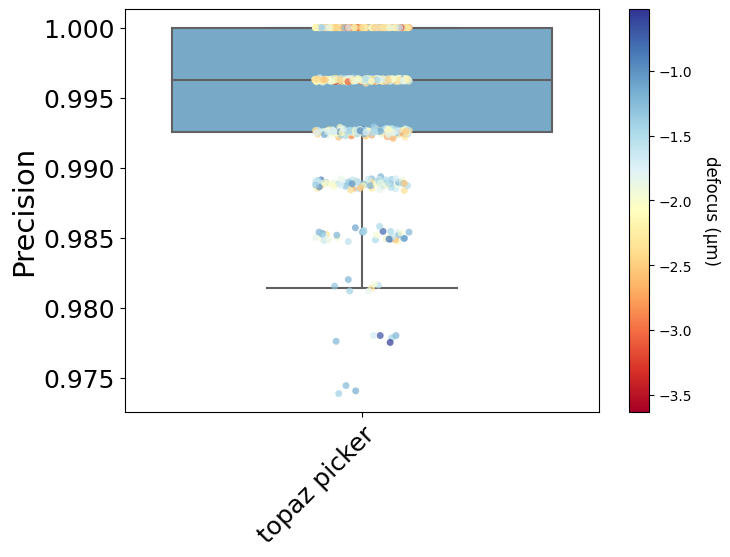

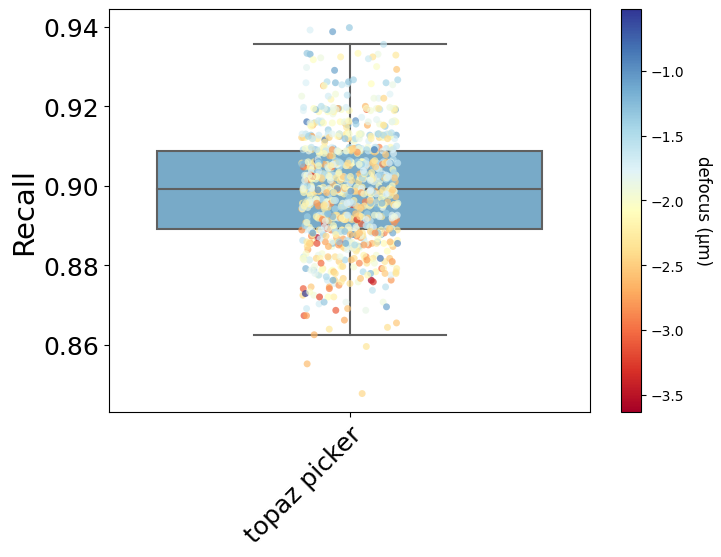

In [22]:
order = []
for r in meta_files:
    if type(r) == str:
        order.append(r)
    else:
        order.append(r[0])  
fig, ax = plot_precision(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Precision", fontsize=21)

# fig.savefig(os.path.join(figures_dir, "precision.pdf"), bbox_inches="tight")

fig, ax = plot_recall(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel("Recall", fontsize=21)

# fig.savefig(os.path.join(figures_dir, "recall.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'recall.pdf')}")


# in text
Compare the local resolution maps for the single-conformation dataset and the conformationally heterogeneous data by masking the LocRes maps and computing the variance in resolution over the map.

mean single conformation: 2.1778156757354736
mean conformationally heterogeneous: 3.0301895141601562
variance single conformation: 0.6089126467704773
variance conformationally heterogeneous: 1.1291253566741943
min single conformation: 0.018280357122421265
min conformationally heterogeneous: 0.024605803191661835
max single conformation: 4.764578819274902
max conformationally heterogeneous: 5.988613605499268


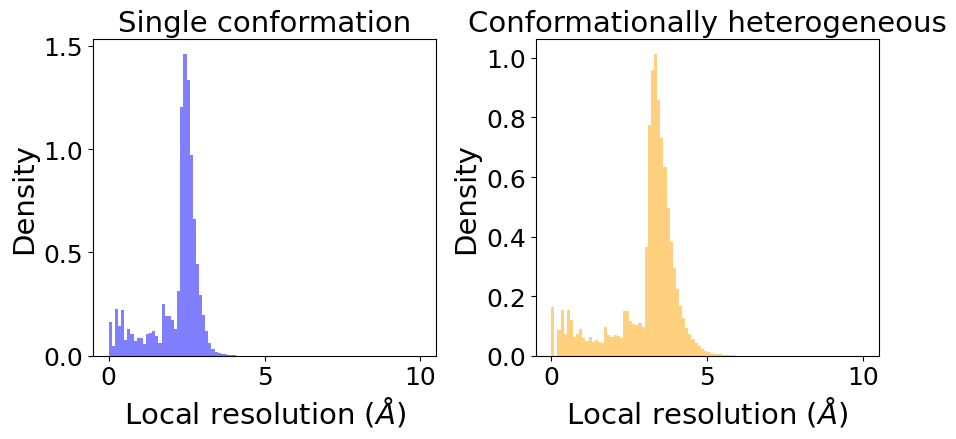

In [10]:
# single-conformation dataset
locres_sc_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/LocalRes/job041/relion_locres.mrc"
mask_sc_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA_single_conformation/MaskCreate/job039/mask.mrc"

# conformationally heterogeneous dataset
locres_ht_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/LocalRes/job037/relion_locres.mrc"
mask_ht_file = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/MaskCreate/job015/mask.mrc"

# load the mrc files
locres_sc = mrcfile.open(locres_sc_file, mode='r')
mask_sc = mrcfile.open(mask_sc_file, mode='r')
locres_sc_data = locres_sc.data * mask_sc.data
locres_sc_data[locres_sc_data == 0] = np.nan
locres_ht = mrcfile.open(locres_ht_file, mode='r')
mask_ht = mrcfile.open(mask_ht_file, mode='r')
locres_ht_data = locres_ht.data * mask_ht.data
locres_ht_data[locres_ht_data == 0] = np.nan

# plot the local resolution
fig, ax = plt.subplots(1, 2, figsize=(4.5*2, 4.5))
ax[0].hist(locres_sc_data.flatten(), bins=100, range=(0, 10), density=True, color="blue", alpha=0.5);
ax[0].set_xlabel("Local resolution ($\AA$)", fontsize=21)
ax[0].set_ylabel("Density", fontsize=21)
ax[0].set_title("Single conformation", fontsize=21)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[1].hist(locres_ht_data.flatten(), bins=100, range=(0, 10), density=True, color="orange", alpha=0.5);
ax[1].set_xlabel("Local resolution ($\AA$)", fontsize=21)
ax[1].set_ylabel("Density", fontsize=21)
ax[1].set_title("Conformationally heterogeneous", fontsize=21)
ax[1].tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

# print the mean and variance of the local resolution
print(f"mean single conformation: {np.nanmean(locres_sc_data)}")
print(f"mean conformationally heterogeneous: {np.nanmean(locres_ht_data)}")
print(f"variance single conformation: {np.nanvar(locres_sc_data)}")
print(f"variance conformationally heterogeneous: {np.nanvar(locres_ht_data)}")
print(f"min single conformation: {np.nanmin(locres_sc_data)}")
print(f"min conformationally heterogeneous: {np.nanmin(locres_ht_data)}")
print(f"max single conformation: {np.nanmax(locres_sc_data)}")
print(f"max conformationally heterogeneous: {np.nanmax(locres_ht_data)}")
